### Ranking multiple systems

In this notebook, we consider the situation where we have scores from multiple different automated scoring systems, each with different levels of performance.  We evaluate these systems against the same as well as different pairs of raters and show that:

1. When using the same pair of raters to evaluate all of the systems, all metrics including PRMSE are able to rank the systems accurately.
2. However, when a different pair of raters is chosen for each system, the conventional agreement metrics are not able to rank the systems accurately whereas PRMSE still does.

In [1]:
import itertools
import json
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from pathlib import Path
from rsmtool.utils.prmse import prmse_true
from simulation.dataset import Dataset
from simulation.utils import (compute_agreement_one_system_one_rater_pair,
                               compute_agreement_multiple_systems_one_rater_pair,
                               compute_ranks_from_metrics)

# define a directory to save figures
figure_dir = Path('../paper_overleaf/figures')

### Step 1: Setup

To set up the experiment, we first load the dataset we have already created and saved in the `making_a_dataset.ipynb` notebook and use that for this experiment.

For convenience and replicability, we have pre-defined many of the parameters that are used in our notebooks and saved them in the file `settings.json`. We load this file below.

In [16]:
# load the dataset file
dataset = Dataset.from_file('../data/default.dataset')

# let's remind ourselves what the dataset looks like
print(dataset)

Dataset (10000 responses, scores in [1, 6], 4 rater categories, 50 raters/category, 5 system categories, 5 systems/category)


In [17]:
# load the experimental settings file
experiment_settings = json.load(open('settings.json', 'r'))

In [18]:
# now get the data frames for our loaded dataset
df_scores, df_rater_metadata, df_system_metadata = dataset.to_frames()

### Step 2: Evaluate all systems against same pair of raters

First, we evaluate the scores assigned by all our simulated systems in the dataset against the same pair of simulated human raters from the dataset. To simulate the more usual scenario, we sample two raters from the "average" rater category.

In [5]:
# define our pre-selected rater category
chosen_rater_category = "average"

# get the list of rater IDs in this category
rater_ids = df_rater_metadata[df_rater_metadata['rater_category'] == chosen_rater_category]['rater_id']

# choose 2 rater IDs randomly from these
chosen_rater_pair = rater_id1, rater_id2 = rater_ids.sample(n=2, random_state=1234567890).values.tolist()

# Print this pair out
print(f'we chose the rater pair: {chosen_rater_pair}')

we chose the rater pair: ['h_107', 'h_101']


Now, we compute the agreement metrics as well as the PRMSE values for all of the simulated systems in our dataset against our pre-selected rater pair.

In [6]:
# initialize some lists that will hold our metric and PRMSE values for each category
metric_dfs = []
prmse_series = []

# iterate over each system category
for system_category in dataset.system_categories:
    
    # get the system IDs that belong to this system category
    system_ids_for_category = df_system_metadata[df_system_metadata['system_category'] == system_category]['system_id']
    
    # compute the agreement metrics for all of the systems in this category against our chosen rater pair
    df_metrics_for_category = compute_agreement_multiple_systems_one_rater_pair(df_scores,
                                                                                system_ids_for_category,
                                                                                chosen_rater_pair[0],
                                                                                chosen_rater_pair[1],
                                                                                include_mean=True)

    # note that `compute_agreement_multiple_systems_one_rater_pair()` returns the metric values
    # against both the average of the two raters' scores as well as the first rater's scores;
    # for this analysis, we choose to use only the metric values against the average
    df_metrics_for_category = df_metrics_for_category[df_metrics_for_category['reference'] == 'h1-h2 mean']
    df_metrics_for_category.drop('reference', axis=1, inplace=True)

    
    # save the system category in the data frame too since we need it for plotting
    df_metrics_for_category['system_category'] = system_category

    # save this metrics dataframe in the list
    metric_dfs.append(df_metrics_for_category)


    # compute the PRMSE values for all of the systems in this category against our chosen ratr pair
    prmse_series_for_category = system_ids_for_category.apply(lambda system_id: prmse_true(df_scores[system_id],
                                                                                            df_scores[[rater_id1, rater_id2]]))
    # save these PRMES values in the list
    prmse_series.append(prmse_series_for_category)
    

# combine all of the per-category agreement metric values into a single data frame
df_metrics_same_rater_pair_with_categories = pd.concat(metric_dfs).reset_index(drop=True)

# and combine all of the per-category PRMSE values and add it as another column in the same data frame
df_metrics_same_rater_pair_with_categories['PRMSE'] = pd.concat(prmse_series)

Now, we need to use each metric to compute the ranks of each of the systems based on the values.

In [7]:
# compute the ranks given the metric values
df_ranks_same_rater_pair = compute_ranks_from_metrics(df_metrics_same_rater_pair_with_categories)

# now compute a longer verssion of this rank data frame that is more amenable to plotting
df_ranks_same_rater_pair_long = df_ranks_same_rater_pair.melt(id_vars=['system_category', 'system_id'],
                                                              var_name='metric',
                                                              value_name='rank')

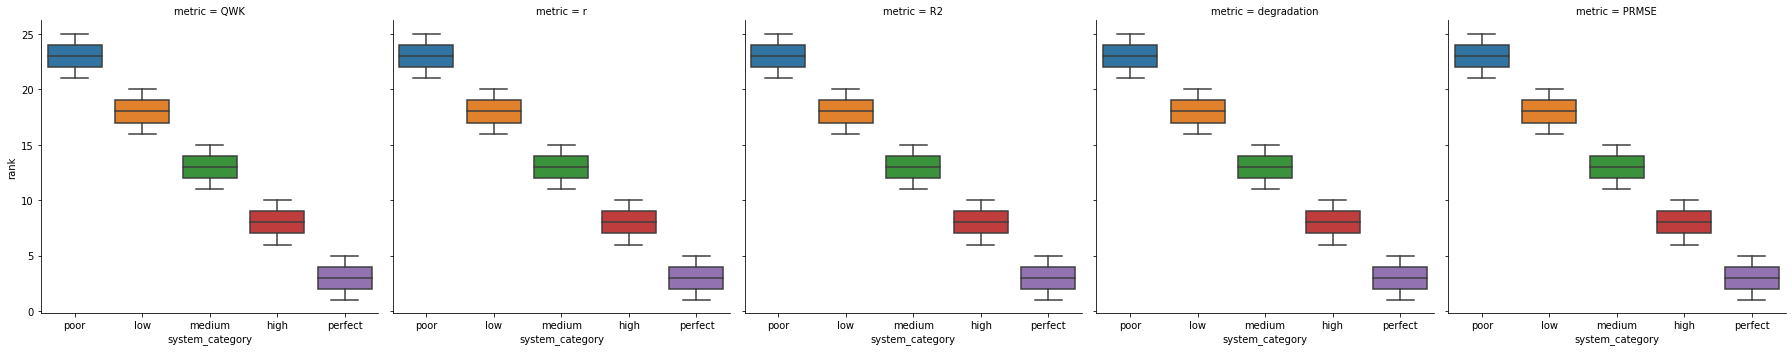

In [8]:
# plot the ranks
sns.catplot(x='system_category', y='rank', data=df_ranks_same_rater_pair_long,
           col='metric', kind='box')
plt.show()

As expected, this plot shows that all of the agreement metrics as well as PRMSE ranks the systems correctly since all of them are being computed against the same rater pair. Note that systems known to have better performance rank "higher". 

### Step 3: Evaluate each systems against a different pair of raters

Now, we change things up and  evaluate the scores assigned by each of our simulated systems in the dataset against a _different_ pair of simulated human raters from the dataset. We always sample both raters from the sam category but diffrent pairs are sampld from diffrent categories so that different systems are evaluated against rater pairs with different level of agreement. 

In [9]:
# first let's get rater pairs within each category
rater_pairs_per_category = df_rater_metadata.groupby('rater_category')['rater_id'].apply(lambda values: itertools.combinations(values, 2))

# next let's combine all possible rater pairs across the categories
combined_rater_pairs = [f"{rater_id1}+{rater_id2}" for rater_id1, rater_id2 in itertools.chain.from_iterable(rater_pairs_per_category.values)]

# finally sample a rater pair for each of the systems
prng = np.random.RandomState(1234567890)
num_systems = dataset.num_systems_per_category * len(dataset.system_categories)
rater_pairs_for_systems = prng.choice(combined_rater_pairs, size=num_systems, replace=False)
rater_pairs_for_systems = [rater_pair.split('+') for rater_pair in rater_pairs_for_systems]

Before we proceed, let's check how different system categories were distributed across different rater pairs. 

In [41]:
# we need to add the information about the systems and rater pairs 
# We can use h1 sincethe pairs are always drawn from the same groups of raters
df_for_evaluation = pd.DataFrame(data=rater_pairs_for_systems, columns=['h1', 'h2'])
df_for_evaluation['system_id'] = df_system_metadata['system_id'].values
df_for_evaluation['system_category'] = df_system_metadata['system_category']
df_for_evaluation_with_category = pd.merge(df_for_evaluation, df_rater_metadata,
                                           left_on='h1', right_on='rater_id' )
xtabs = pd.crosstab(df_for_evaluation_with_category['system_category'],
                    df_for_evaluation_with_category['rater_category']).loc[dataset.system_categories,
                                                                            dataset.rater_categories]
xtabs

rater_category,low,moderate,average,high
system_category,,,,
poor,1,3,0,1
low,0,0,2,3
medium,3,0,1,1
high,2,1,1,1
perfect,2,0,2,1


As the table shows, we see that systems in different categories were evaluated against rater pairs with different level of agreement. For example, 3 out of 5 systems in "low" category were evaluated against raters with "high" agreement. At the same time for systems in "medium" category, 3 out of 5 systems were evaluated against raters with "low" agreement. 

In [39]:
print(xtabs.to_latex())

\begin{tabular}{lrrrrr}
\toprule
system\_category &  poor &  low &  medium &  high &  perfect \\
rater\_category &       &      &         &       &          \\
\midrule
low            &     1 &    0 &       3 &     2 &        2 \\
moderate       &     3 &    0 &       0 &     1 &        0 \\
average        &     0 &    2 &       1 &     1 &        2 \\
high           &     1 &    3 &       1 &     1 &        1 \\
\bottomrule
\end{tabular}



Next, we compute the values of the conventional agreement metrics and PRMSE for each system against its corresponding rater pair.

In [44]:
# initialize an empty list to hold the metric values for each system ID
metric_values_list = []

# iterate over each system ID
for system_id, rater_id1, rater_id2 in zip(df_for_evaluation['system_id'],
                                           df_for_evaluation['h1'],
                                           df_for_evaluation['h2']):
        
    # compute the agreement metrics for all of the systems in this category against our chosen rater pair
    metric_values, _ = compute_agreement_one_system_one_rater_pair(df_scores,
                                                                   system_id,
                                                                   rater_id1,
                                                                   rater_id2,
                                                                   include_mean=True)

    # now compute  the PRMSE value of the system against the two raters
    metric_values['PRMSE'] = prmse_true(df_scores[system_id], df_scores[[rater_id1, rater_id2]])
    
    # save the system ID since we will need it later
    metric_values['system_id'] = system_id
    
    # save this list of metrics in the list
    metric_values_list.append(metric_values)

# now create a data frame with all of the metric values for all system IDs
df_metrics_different_rater_pairs = pd.DataFrame(metric_values_list)

# merge in the system category from the metadata since we need that for plotting
df_metrics_different_rater_pairs_with_categories = df_metrics_different_rater_pairs.merge(df_system_metadata,
                                                                                          left_on='system_id',
                                                                                          right_on='system_id')

# keep only the columns we need
df_metrics_different_rater_pairs_with_categories = df_metrics_different_rater_pairs_with_categories[['system_id',
                                                                                                     'system_category',
                                                                                                     'r',
                                                                                                     'QWK',
                                                                                                     'R2',
                                                                                                     'degradation',
                                                                                                     'PRMSE']]

Now that we have computed the metrics, we can plot each simulated system's measured performance via each of the metrics against its known performance, as indicated by its system category.

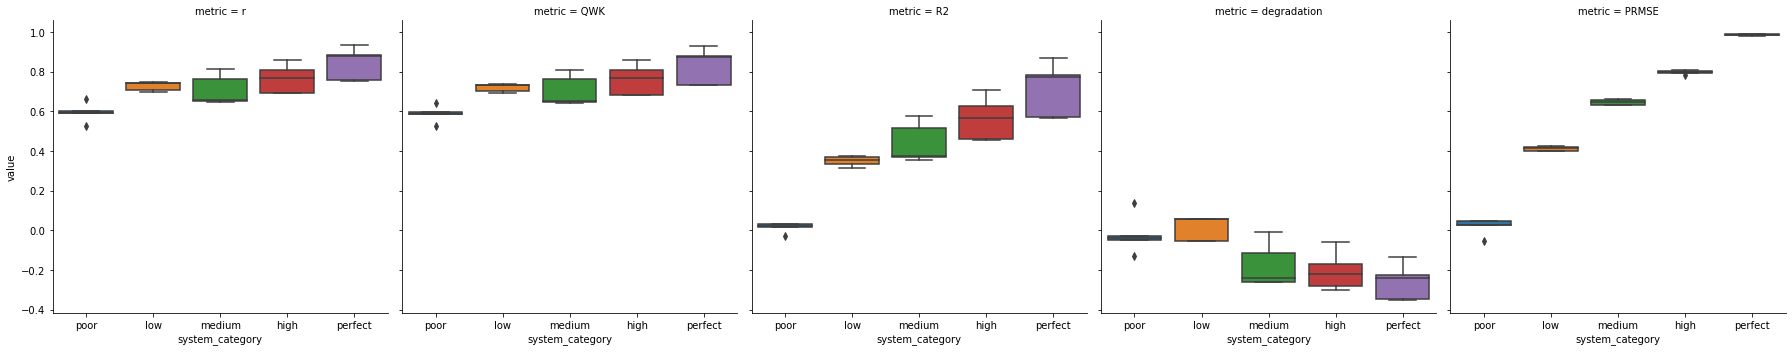

In [45]:
# now create a longer version of this data frame that's more amenable to plotting
df_metrics_different_rater_pairs_with_categories_long = df_metrics_different_rater_pairs_with_categories.melt(id_vars=['system_id', 'system_category'],
                                                                                                  var_name='metric')
# plot the metric values by system category
ax = sns.catplot(col='metric',
                 y='value',
                 x='system_category',
                 data=df_metrics_different_rater_pairs_with_categories_long,
                 kind='box',
                 order=dataset.system_categories)
plt.show()

From this plot, we can see that only PRMSE values accurately separate the systems from each other whereas the other metrics are not able to do. Next, let's plot how the different systems are ranked by each of the metrics and also compare these ranks to the ranks from the same-rater scenario.

In [46]:
# get the ranks for the metrics
df_ranks_different_rater_pairs = compute_ranks_from_metrics(df_metrics_different_rater_pairs_with_categories)

# and now get a longer version of this data frame that's more amenable to plotting
df_ranks_different_rater_pairs_long = df_ranks_different_rater_pairs.melt(id_vars=['system_category', 'system_id'],
                                                                          var_name='metric',
                                                                          value_name='rank')

# we also merge in the ranks from the same-rater scenario and distinguish the two sets of ranks with suffixes
df_all_ranks_long = df_ranks_different_rater_pairs_long.merge(df_ranks_same_rater_pair_long,
                                                              left_on=['system_id', 'system_category', 'metric'],
                                                              right_on=['system_id', 'system_category', 'metric'],
                                                              suffixes=('_diff', '_same'))

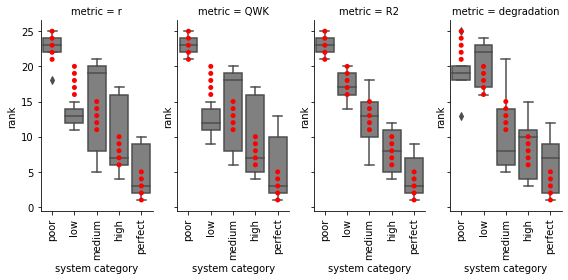

In [48]:
# now make a plot that shows the comparison of the two sets of ranks
# I have excluded PRMSE to generate the plot for the paper. 
# This filtering will be removed before the release. 
g = sns.FacetGrid(df_all_ranks_long[df_all_ranks_long['metric']!='PRMSE'], col='metric', height=4, aspect=0.5)
g.map(sns.boxplot, 'system_category', 'rank_diff', order=dataset.system_categories, color='grey')
g.map(sns.stripplot, 'system_category', 'rank_same', order=dataset.system_categories, color='red', jitter=False)
(g.set_xticklabels(dataset.system_categories, rotation=90)
  .set(xlabel='system category')
  .set(ylabel='rank'))
plt.tight_layout(h_pad=1.0)
plt.savefig(figure_dir / 'system_comparison.png')
plt.show()

As this plot shows, only the PRMSE metric is still able to rank the systems accurately whereas all the other metrics are not. We can also make another plot that shows a more direct comparison between $R^2$ and PRMSE.

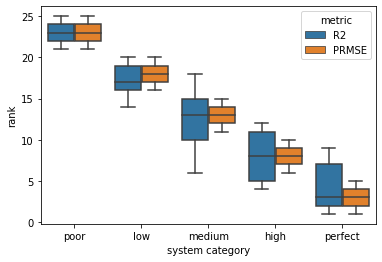

In [14]:
# plot PRMSE and R2 ranks only
df_r2_prmse_ranks_long = df_all_ranks_long[df_all_ranks_long['metric'].isin(['R2', 'PRMSE'])]
ax = sns.boxplot(x='system_category',
                 y='rank_diff',
                 hue='metric',
                 hue_order=['R2', 'PRMSE'],
                 data=df_r2_prmse_ranks_long,)
ax.set_xlabel('system category')
ax.set_ylabel('rank')
plt.savefig(figure_dir / 'prmse_comparison.png')
plt.show()

Again, this plot shows that PRMSE is much better behaved when it comes to comparing/ranking systems than $R^2$.